In [1]:
import json
import os
import shutil

import albumentations
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedShuffleSplit,
    train_test_split,
)
from tensorflow import keras
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")
from Generator import Generator
%matplotlib inline

In [2]:
PATH = "/app/_data/"
PATH_JSON1 = "/app/_data/json/1071_big.json"
PATH_JSON2 = "/app/_data/json/part_2_bb.json"
BATCH_SIZE = 64
SEED = 37
IMAGE_SIZE = 224
TRAIN_IMG_PATH = "/app/_data/train_images/"

In [3]:
df_bboxes = pd.read_csv("/app/_data/df_csv/df_boxes_colab.csv", index_col=[0])

In [4]:
with open(PATH_JSON1, "r") as read_file:
    data1 = json.load(read_file)
with open(PATH_JSON2, "r") as read_file:
    data2 = json.load(read_file)

In [5]:
data1.extend(data2)

In [6]:
len(data1)

1564

In [7]:
df = pd.DataFrame()
data = data1
for i in range(len(data)):
    img = data[i]["file_upload"].split(".")[0].split("_")[0] + ".jpg"
    df.loc[img, "image"] = img
    annot = data[i]["annotations"][0]["result"][0]["value"]
    df.loc[img, "x_min"] = annot["x"] / 100
    df.loc[img, "y_min"] = annot["y"] / 100
    df.loc[img, "x_max"] = (annot["x"] + annot["width"]) / 100
    df.loc[img, "y_max"] = (annot["y"] + annot["height"]) / 100

In [8]:
df

image     x_min     y_min     x_max  \
fa529f125a27603e.jpg  fa529f125a27603e.jpg  0.000000  0.157766  0.973333   
fa888b5a2536b78a.jpg  fa888b5a2536b78a.jpg  0.094667  0.225631  0.862667   
fa900bfc9dc701aa.jpg  fa900bfc9dc701aa.jpg  0.137371  0.117845  0.706667   
fa952bc48883377a.jpg  fa952bc48883377a.jpg  0.081371  0.071937  0.934667   
fa958a3532aa99c9.jpg  fa958a3532aa99c9.jpg  0.186705  0.375333  0.641333   
...                                    ...       ...       ...       ...   
fa95acc530b602de.jpg  fa95acc530b602de.jpg  0.218705  0.279524  0.673333   
fa95d1609bd90dc4.jpg  fa95d1609bd90dc4.jpg  0.098705  0.032042  0.918667   
fa097addd4f84260.jpg  fa097addd4f84260.jpg  0.028038  0.080080  0.910667   
fa108f246b1ceb1e.jpg  fa108f246b1ceb1e.jpg  0.193371  0.095889  0.781371   
fa0297d21fc123cb.jpg  fa0297d21fc123cb.jpg  0.118705  0.111857  0.853333   

                         y_max  
fa529f125a27603e.jpg  0.850299  
fa888b5a2536b78a.jpg  0.794411  
fa900bfc9dc701aa.jpg  0.866267  
fa952bc48883377a.jpg  0.700599  
fa958a3532aa99c9.jpg  0.808383  
...                        ...  
fa95acc530b602de.jpg  0.684631  
fa95d1609bd90dc4.jpg  0.865009  
fa097addd4f84260.jpg  0.742000  
fa108f246b1ceb1e.jpg  1.000000  
fa0297d21fc123cb.jpg  0.794411  

[1516 rows x 5 columns]

In [9]:
img = cv2.imread("/app/_data/train_images/fa888b5a2536b78a.jpg")
img = cv2.resize(img, [100, 100], interpolation=cv2.INTER_LINEAR)
img = np.concatenate([img, img], axis=-1)

In [10]:
shutil.rmtree("/app/_data/cache_segm/")
gen = Generator(
    df=df,
    images_dir="/app/_data/train_images/",
    cache_dir="/app/_data/cache_segm/",
    batch_size=16,
    img_size=380,
    n_chanels=3,
    shuffle=True,
    augment=True,
    normalize=True,
)

In [11]:
a, b = next(iter(gen))

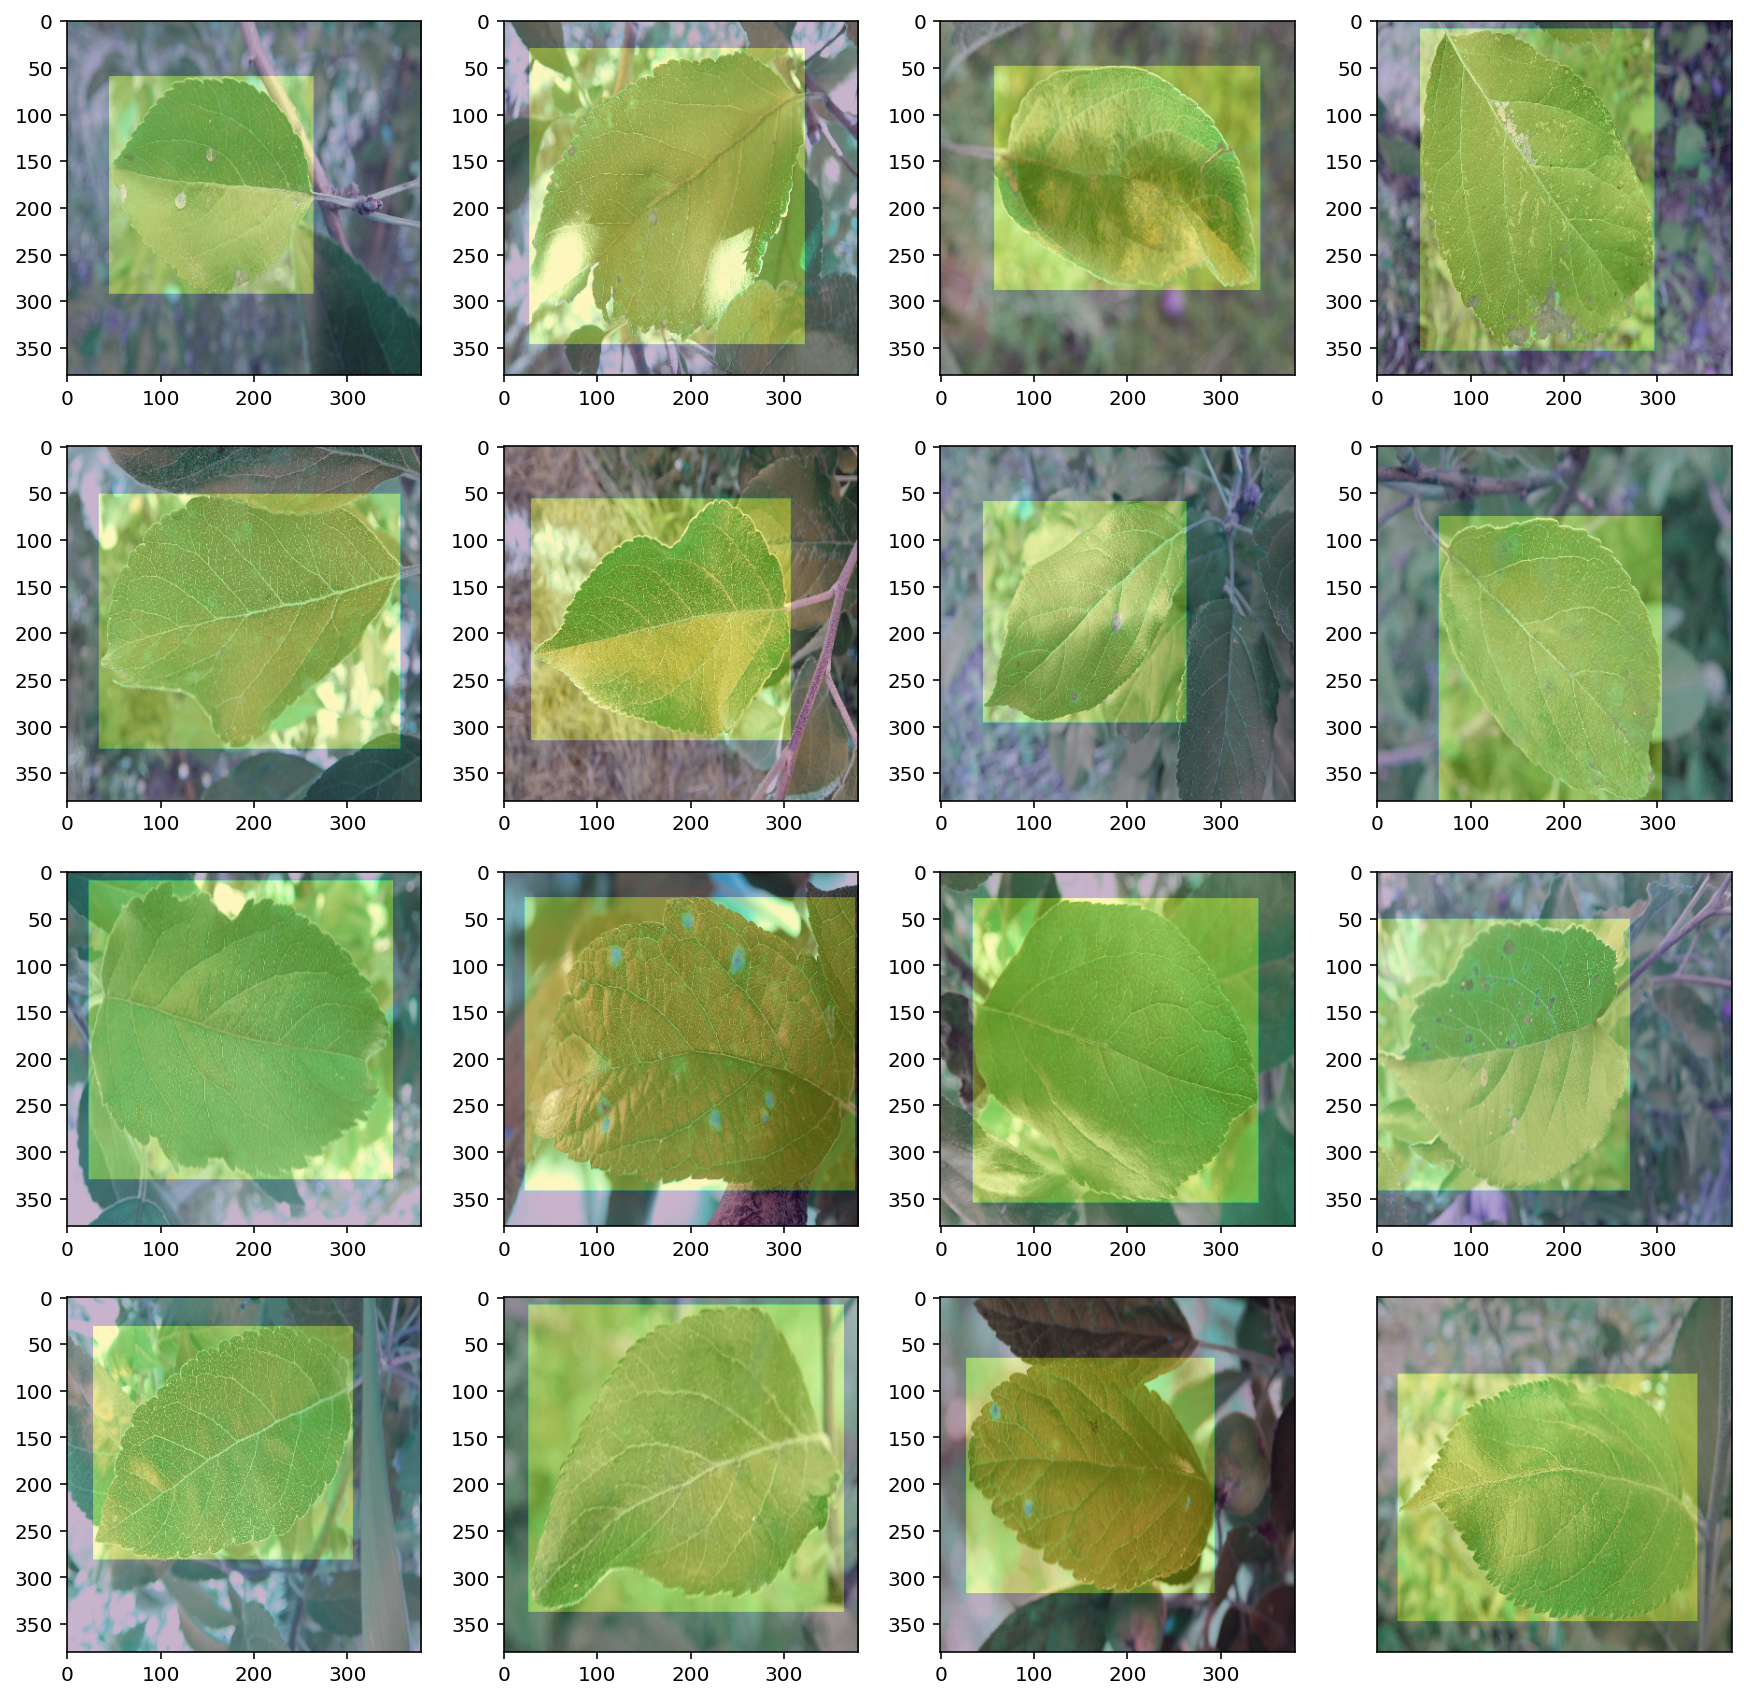

In [12]:
plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(a[i][:, :, :3])
    plt.imshow(b[i], alpha=0.3)
plt.yticks([])
plt.xticks([])
plt.show();

In [13]:
def get_model():
    inputs = keras.layers.Input(shape=(380, 380, 3))
    base_model = keras.applications.EfficientNetB4(
        weights="imagenet", include_top=False
    )
    x = base_model(inputs)
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)

    outputs = keras.layers.Dense(100, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(lr=0.0005),
        metrics=[
            "acc",
        ],
    )
    return model

In [14]:
base_model = keras.applications.EfficientNetB4(
    weights="imagenet", include_top=False
)

71688192/71686520 [==============================] - 1s 0us/step


In [15]:
base_model(keras.layers.Input(shape=(380, 380, 3)))

<KerasTensor: shape=(None, 11, 11, 1792) dtype=float32 (created by layer 'efficientnetb4')>

In [37]:
# base_model(a[0])

In [18]:
for i, l in enumerate(base_model.layers):
    print(i, l.name,'\n', l.input)

0 input_1 
 KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
1 rescaling 
 KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
2 normalization 
 KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), name='rescaling/add:0', description="created by layer 'rescaling'")
3 stem_conv_pad 
 KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), name='normalization/truediv:0', description="created by layer 'normalization'")
4 stem_conv 
 KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), name='stem_conv_pad/Pad:0', description="created by layer 'stem_conv_pad'")
5 stem_bn 
 KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 48), dtype=tf.float32, name=None), name='ste

In [39]:
base_model.get_layer('stem_activation').output

<KerasTensor: shape=(None, None, None, 48) dtype=float32 (created by layer 'stem_activation')>

In [40]:
base_model.get_layer('block2d_add').output

<KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'block2d_add')>

In [41]:
base_model.layers[29].output

<KerasTensor: shape=(None, None, None, 144) dtype=float32 (created by layer 'block2a_expand_conv')>